# Marine Gasoil 9

1. 원유 가격 데이터 추가 (Dubai, Brent, WTI)
    - Data leakage 방지를 위해 test size만큼 삭제
2. Lag feature 조정
    - data splitting 전에 적용, 과거 데이터를 사용하므로 data leakage와 상관 X
    - 다만 test size보다 큰 기간의 값을 적용해야 함
3. Rolling means 다시 추가
    - Data leakage 방지를 위해 data splitting 이후에 적용, sliding window 사용해 test 데이터에 적용

In [30]:
filepath = './03_oil_value_ts.csv'
fuel_type = 'Marine Gasoil'
target_column = 'Marine Gasoil 9'
test_days = 14
lag_days_list = [14, 30, 91, 182]
rolling_days_list = [14, 30, 91, 182]
window_size = 14
period = 20
validation_days = 30
timeseriessplit = 5
prediction_val = 'pred_val'
prediction_test = 'pred_test'

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

warnings.filterwarnings('ignore')
sns.set(font_scale=2.0)
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

dt = pd.read_csv(filepath)
dt = dt[dt['Statistics'] == 'CLOSE'].drop(['Code', 'Country', 'Viscosity'], axis=1)
dt['Fuel Type'] = dt['Fuel Type'] + ' ' + (dt.groupby('Fuel Type').cumcount() + 1).astype(str)
date_columns = dt.columns[6:]
dt_fuel = dt.loc[:, date_columns].T
dt_fuel.columns = dt['Fuel Type']
dt_fuel.index = pd.to_datetime(dt_fuel.index)
dt_fuel = dt_fuel.iloc[:, :-3]

dt_fuel = dt_fuel.filter(regex=fuel_type)
ts = dt_fuel[target_column]
ts = pd.DataFrame(ts)
ts.index.name = 'Date'
ts.rename(columns={target_column: target_column + '_Price'}, inplace=True)
ts = ts.asfreq('B')
ts = ts.interpolate(method='linear')
ts

,Marine Gasoil 9_Price
Date,
2022-01-04,775.5
2022-01-05,800.5
2022-01-06,802.5
2022-01-07,806.5
2022-01-10,813.5
...,...
2024-04-16,876.5
2024-04-17,865.5
2024-04-18,859.5


In [32]:
crude_oil = pd.read_csv('./crude_oil_price.csv')

In [33]:
crude_oil['Date'] = pd.to_datetime(crude_oil['Date'])
crude_oil.set_index('Date', inplace=True)
crude_oil

,Dubai,Brent,WTI
Date,,,
2022-01-04,77.51,80.00,76.99
2022-01-05,78.40,80.80,77.85
2022-01-06,78.83,81.99,79.46
2022-01-07,80.55,81.75,78.90
2022-01-10,80.36,80.87,78.23
...,...,...,...
2024-04-18,87.43,87.11,82.73
2024-04-19,87.72,87.29,83.14
2024-04-22,86.41,87.00,82.85


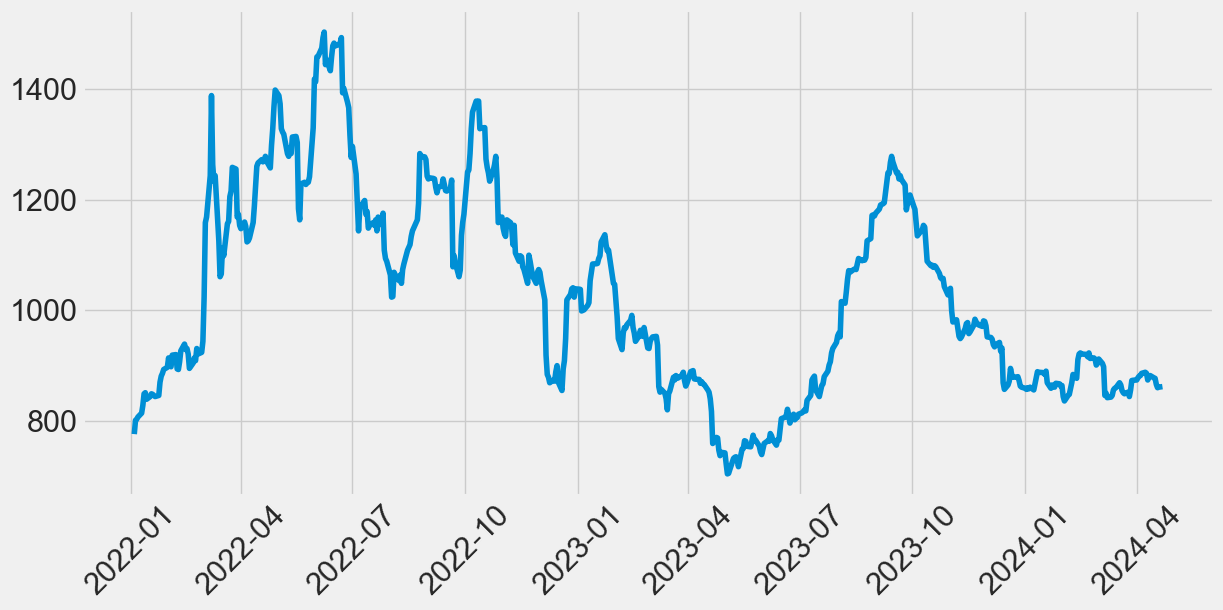

In [34]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6
plt.xticks(rotation=45)
plt.plot(ts);

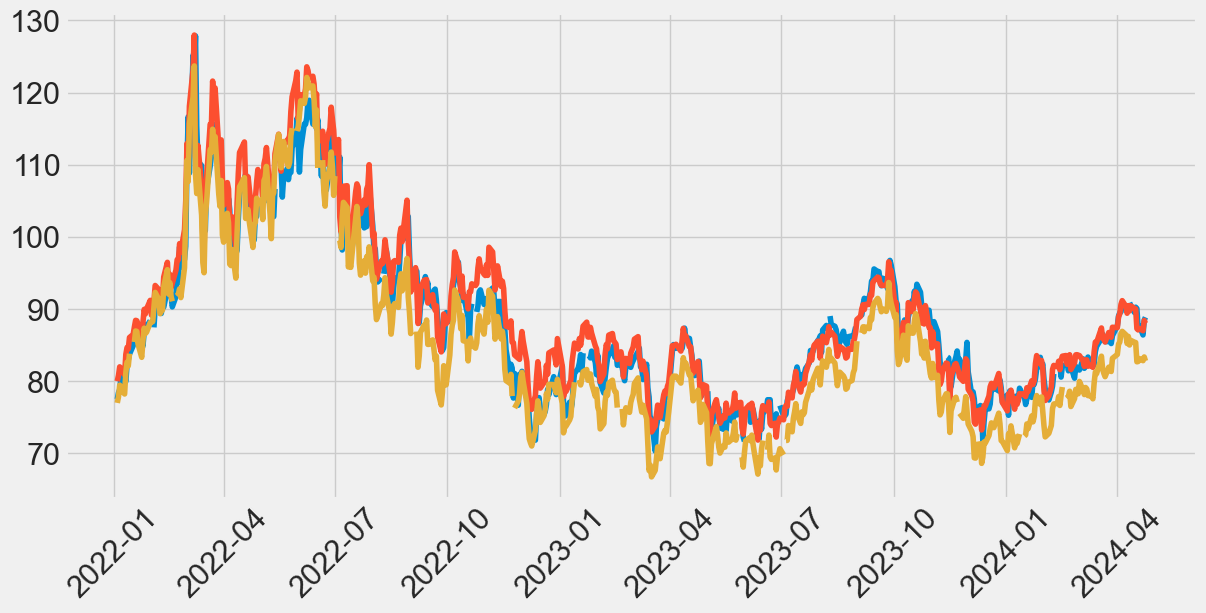

In [35]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6
plt.xticks(rotation=45)
plt.plot(crude_oil);

In [36]:
ts_merge = ts.join(crude_oil, how='left')
ts_merge

,Marine Gasoil 9_Price,Dubai,Brent,WTI
Date,,,,
2022-01-04,775.5,77.51,80.00,76.99
2022-01-05,800.5,78.40,80.80,77.85
2022-01-06,802.5,78.83,81.99,79.46
2022-01-07,806.5,80.55,81.75,78.90
2022-01-10,813.5,80.36,80.87,78.23
...,...,...,...,...
2024-04-16,876.5,90.26,90.02,85.36
2024-04-17,865.5,90.07,87.29,82.69
2024-04-18,859.5,87.43,87.11,82.73


In [37]:
ts_merge.isna().sum()

Marine Gasoil 9_Price     0
Dubai                    25
Brent                     7
WTI                      23
dtype: int64

In [38]:
ts_merge = ts_merge.interpolate(method='linear')
ts_merge.isna().sum()

Marine Gasoil 9_Price    0
Dubai                    0
Brent                    0
WTI                      0
dtype: int64

In [39]:
ts_merge

,Marine Gasoil 9_Price,Dubai,Brent,WTI
Date,,,,
2022-01-04,775.5,77.51,80.00,76.99
2022-01-05,800.5,78.40,80.80,77.85
2022-01-06,802.5,78.83,81.99,79.46
2022-01-07,806.5,80.55,81.75,78.90
2022-01-10,813.5,80.36,80.87,78.23
...,...,...,...,...
2024-04-16,876.5,90.26,90.02,85.36
2024-04-17,865.5,90.07,87.29,82.69
2024-04-18,859.5,87.43,87.11,82.73


In [40]:
ts_merge['Year'] = ts_merge.index.year
ts_merge['Quarter'] = ts_merge.index.quarter
ts_merge['Month'] = ts_merge.index.month
ts_merge['Dayofweek'] = ts_merge.index.dayofweek
ts_merge['Dayofmonth'] = ts_merge.index.day
ts_merge['Weekofyear'] = ts_merge.index.isocalendar().week
ts_merge['Dayofyear'] = ts_merge.index.dayofyear
ts_merge

,Marine Gasoil 9_Price,Dubai,Brent,WTI,Year,Quarter,Month,Dayofweek,Dayofmonth,Weekofyear,Dayofyear
Date,,,,,,,,,,,
2022-01-04,775.5,77.51,80.00,76.99,2022,1,1,1,4,1,4
2022-01-05,800.5,78.40,80.80,77.85,2022,1,1,2,5,1,5
2022-01-06,802.5,78.83,81.99,79.46,2022,1,1,3,6,1,6
2022-01-07,806.5,80.55,81.75,78.90,2022,1,1,4,7,1,7
2022-01-10,813.5,80.36,80.87,78.23,2022,1,1,0,10,2,10
...,...,...,...,...,...,...,...,...,...,...,...
2024-04-16,876.5,90.26,90.02,85.36,2024,2,4,1,16,16,107
2024-04-17,865.5,90.07,87.29,82.69,2024,2,4,2,17,16,108
2024-04-18,859.5,87.43,87.11,82.73,2024,2,4,3,18,16,109


In [41]:
def add_business_day_lags(df: pd.DataFrame, col_name: str, lag_days_list: list) -> pd.DataFrame:
    for days in lag_days_list:
        df[f'{col_name}_lag{days}'] = df[col_name].shift(days)
    df = df.fillna(method='bfill').fillna(method='ffill')
    return df

ts_merge = add_business_day_lags(ts_merge, target_column + '_Price', lag_days_list)
ts_merge.tail(30)

,Marine Gasoil 9_Price,Dubai,Brent,WTI,Year,Quarter,Month,Dayofweek,Dayofmonth,Weekofyear,Dayofyear,Marine Gasoil 9_Price_lag14,Marine Gasoil 9_Price_lag30,Marine Gasoil 9_Price_lag91,Marine Gasoil 9_Price_lag182
Date,,,,,,,,,,,,,,,
2024-03-12,845.5,82.84,81.92,77.56,2024,1,3,1,12,11,72,915.5,862.5,982.500000,811.500000
2024-03-13,855.5,82.22,84.03,79.72,2024,1,3,2,13,11,73,922.5,863.5,967.500000,814.166667
2024-03-14,858.5,84.09,85.42,81.26,2024,1,3,3,14,11,74,912.5,843.5,952.500000,816.833333
2024-03-15,859.5,84.81,85.34,81.04,2024,1,3,4,15,11,75,913.5,835.5,948.500000,819.500000
2024-03-18,868.5,85.65,86.89,82.72,2024,1,3,0,18,12,78,911.5,845.5,951.500000,817.500000
2024-03-19,864.5,86.43,87.38,83.47,2024,1,3,1,19,12,79,900.5,847.5,966.500000,836.500000
2024-03-20,854.5,86.51,85.95,81.68,2024,1,3,2,20,12,80,903.5,858.5,975.500000,845.500000
2024-03-21,850.5,86.00,85.78,81.07,2024,1,3,3,21,12,81,911.5,868.5,977.500000,873.500000
2024-03-22,848.5,85.49,85.43,80.63,2024,1,3,4,22,12,82,903.5,883.5,957.500000,877.500000


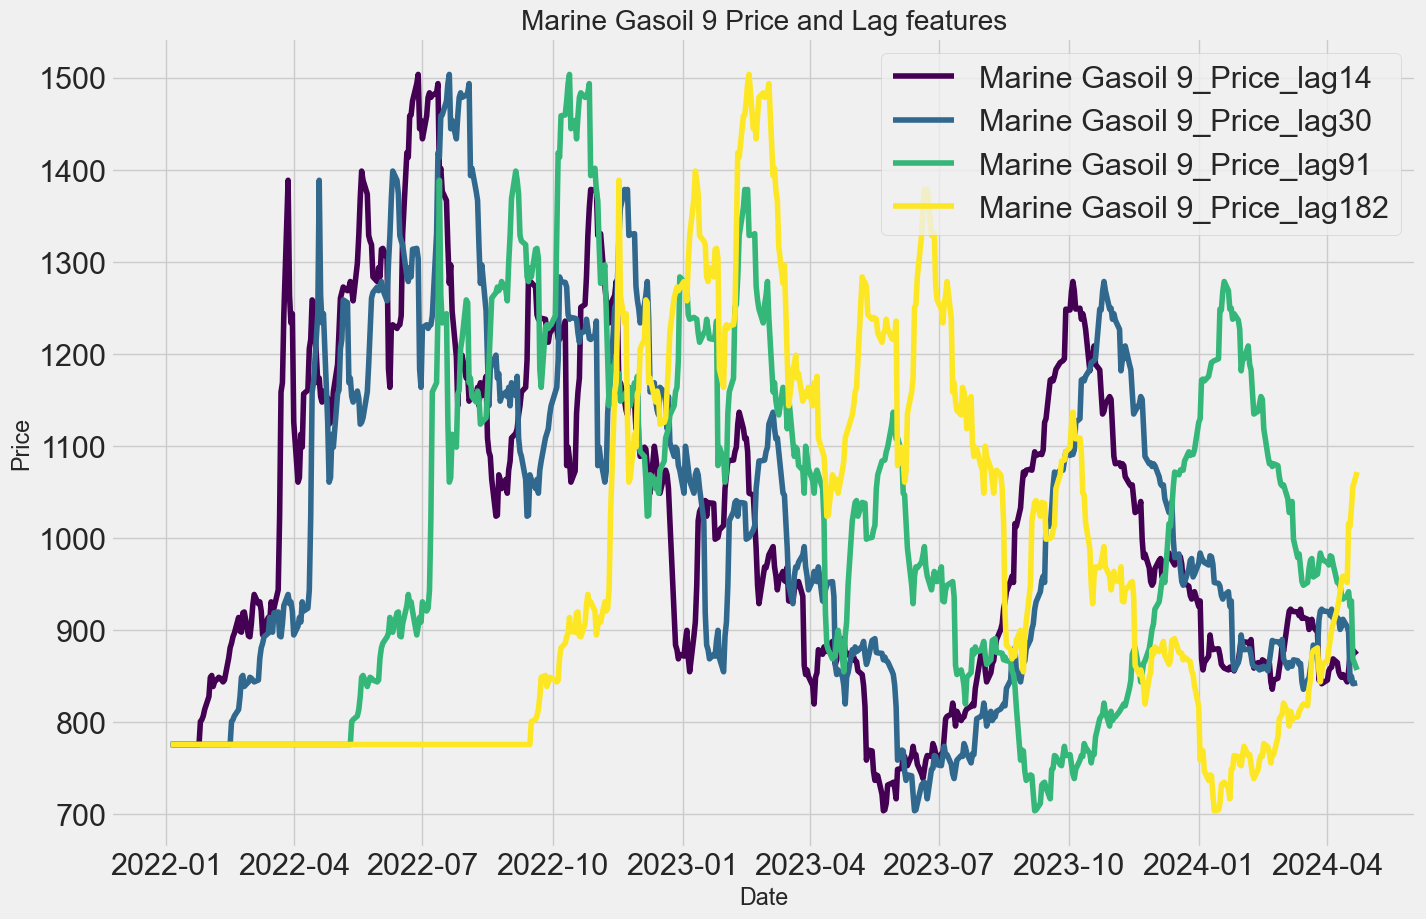

In [42]:
columns_to_plot = [
    f"{target_column + '_Price'}_lag{days}"
    for days in lag_days_list
]

cmap = plt.cm.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(columns_to_plot)))

plt.figure(figsize=(15, 10))

for col, color in zip(columns_to_plot, colors):
    plt.plot(ts_merge.index, ts_merge[col], label=col, color=color)

plt.title('Marine Gasoil 9 Price and Lag features')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [43]:
last_date = ts_merge.index.max()
test_start_date = last_date - pd.Timedelta(days=test_days)  # test date 입력 변수
train_val = ts_merge.loc[ts_merge.index <= test_start_date]
test = ts_merge.loc[ts_merge.index > test_start_date]
 
print(f"Training and validation set shape: {train_val.shape}")
print(f"Test set shape: {test.shape}")

# data leakage 방지를 위해 test 사이즈만큼 원유 가격 삭제
dubai_index = test.columns.get_loc('Dubai')
brent_index = test.columns.get_loc('Brent')
wti_index = test.columns.get_loc('WTI')

test.iloc[-len(test):, [dubai_index, brent_index, wti_index]] = np.nan
test

Training and validation set shape: (590, 15)
Test set shape: (10, 15)


,Marine Gasoil 9_Price,Dubai,Brent,WTI,Year,Quarter,Month,Dayofweek,Dayofmonth,Weekofyear,Dayofyear,Marine Gasoil 9_Price_lag14,Marine Gasoil 9_Price_lag30,Marine Gasoil 9_Price_lag91,Marine Gasoil 9_Price_lag182
Date,,,,,,,,,,,,,,,
2024-04-09,885.5,NaN,NaN,NaN,2024,2,4,1,9,15,100,854.5,911.5,950.5,930.5
2024-04-10,873.5,NaN,NaN,NaN,2024,2,4,2,10,15,101,850.5,900.5,947.5,941.5
2024-04-11,878.5,NaN,NaN,NaN,2024,2,4,3,11,15,102,848.5,903.5,937.5,953.5
2024-04-12,881.5,NaN,NaN,NaN,2024,2,4,4,12,15,103,851.5,911.5,933.5,958.5
2024-04-15,877.5,NaN,NaN,NaN,2024,2,4,0,15,16,106,843.5,903.5,937.5,951.5
2024-04-16,876.5,NaN,NaN,NaN,2024,2,4,1,16,16,107,855.5,897.5,941.5,1015.5
2024-04-17,865.5,NaN,NaN,NaN,2024,2,4,2,17,16,108,872.5,845.5,925.5,1012.5
2024-04-18,859.5,NaN,NaN,NaN,2024,2,4,3,18,16,109,873.0,849.5,931.5,1032.5
2024-04-19,860.5,NaN,NaN,NaN,2024,2,4,4,19,16,110,873.5,841.5,868.5,1055.5


In [44]:
# 이동평균을 추가하는 함수
def add_rolling_mean(df:pd.DataFrame, col_name:str, window_list:list)->pd.DataFrame:
    for window in window_list:
        df[col_name + f'_rolling{window}'] = df[col_name].rolling(window).mean().fillna(method='bfill')
    return df

train_val = add_rolling_mean(train_val, target_column + '_Price', rolling_days_list)
test = add_rolling_mean(test, target_column + '_Price', rolling_days_list)

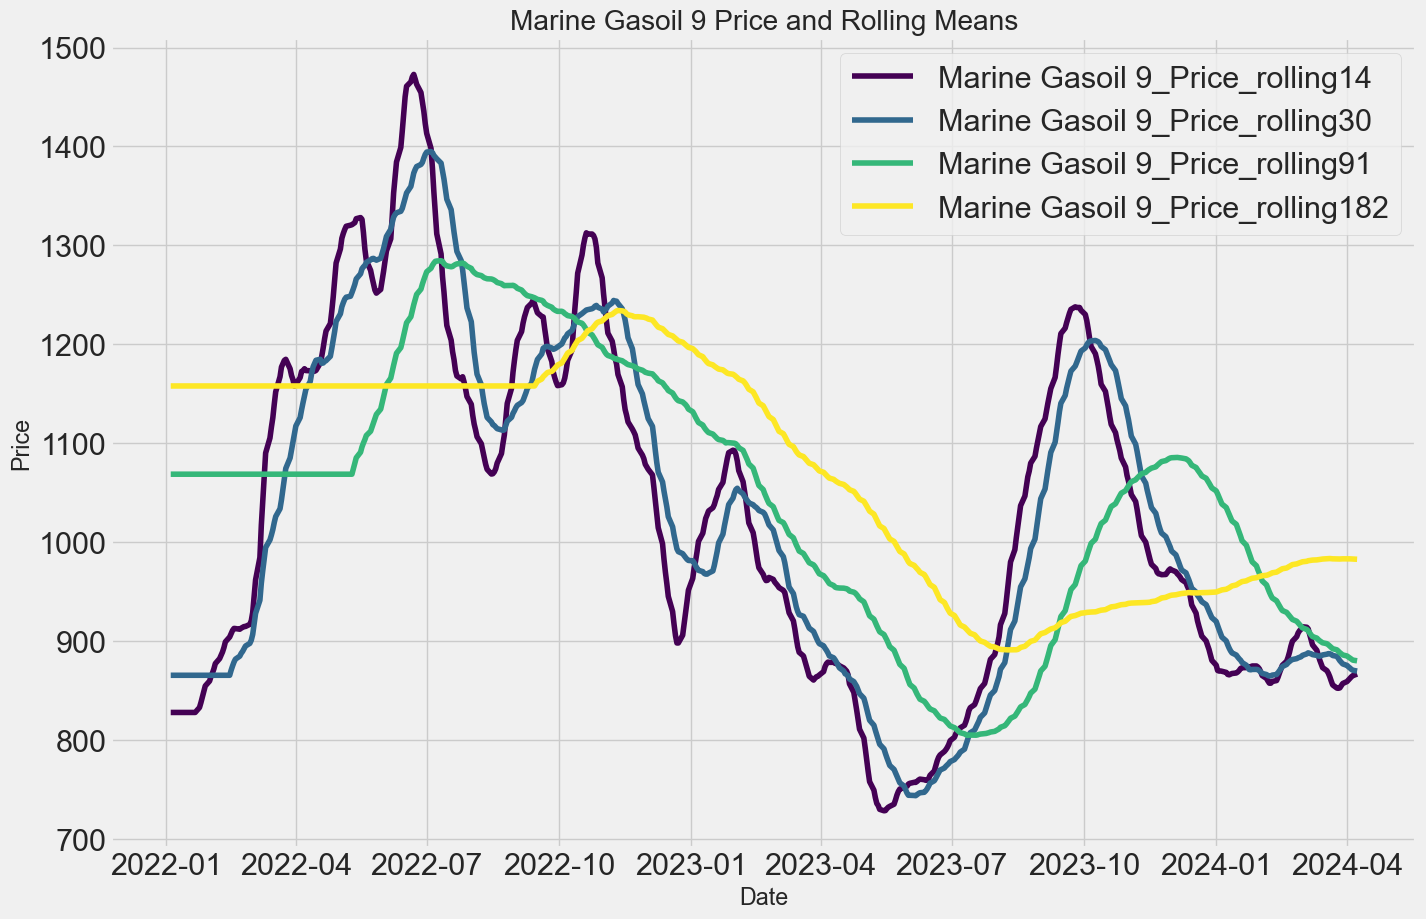

In [45]:
columns_to_plot = [
    f"{target_column + '_Price'}_rolling{days}"
    for days in rolling_days_list
]

cmap = plt.cm.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(columns_to_plot)))

plt.figure(figsize=(15, 10))

for col, color in zip(columns_to_plot, colors):
    plt.plot(train_val.index, train_val[col], label=col, color=color)

plt.title('Marine Gasoil 9 Price and Rolling Means')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [46]:
test

,Marine Gasoil 9_Price,Dubai,Brent,WTI,Year,Quarter,Month,Dayofweek,Dayofmonth,Weekofyear,Dayofyear,Marine Gasoil 9_Price_lag14,Marine Gasoil 9_Price_lag30,Marine Gasoil 9_Price_lag91,Marine Gasoil 9_Price_lag182,Marine Gasoil 9_Price_rolling14,Marine Gasoil 9_Price_rolling30,Marine Gasoil 9_Price_rolling91,Marine Gasoil 9_Price_rolling182
Date,,,,,,,,,,,,,,,,,,,
2024-04-09,885.5,NaN,NaN,NaN,2024,2,4,1,9,15,100,854.5,911.5,950.5,930.5,NaN,NaN,NaN,NaN
2024-04-10,873.5,NaN,NaN,NaN,2024,2,4,2,10,15,101,850.5,900.5,947.5,941.5,NaN,NaN,NaN,NaN
2024-04-11,878.5,NaN,NaN,NaN,2024,2,4,3,11,15,102,848.5,903.5,937.5,953.5,NaN,NaN,NaN,NaN
2024-04-12,881.5,NaN,NaN,NaN,2024,2,4,4,12,15,103,851.5,911.5,933.5,958.5,NaN,NaN,NaN,NaN
2024-04-15,877.5,NaN,NaN,NaN,2024,2,4,0,15,16,106,843.5,903.5,937.5,951.5,NaN,NaN,NaN,NaN
2024-04-16,876.5,NaN,NaN,NaN,2024,2,4,1,16,16,107,855.5,897.5,941.5,1015.5,NaN,NaN,NaN,NaN
2024-04-17,865.5,NaN,NaN,NaN,2024,2,4,2,17,16,108,872.5,845.5,925.5,1012.5,NaN,NaN,NaN,NaN
2024-04-18,859.5,NaN,NaN,NaN,2024,2,4,3,18,16,109,873.0,849.5,931.5,1032.5,NaN,NaN,NaN,NaN
2024-04-19,860.5,NaN,NaN,NaN,2024,2,4,4,19,16,110,873.5,841.5,868.5,1055.5,NaN,NaN,NaN,NaN


In [47]:
decomposition = seasonal_decompose(train_val[target_column + '_Price'], period=period)   # period 설정 입력 변수

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본 - 추세 - 계절성

train_val['trend'] = trend
train_val['seasonal'] = seasonal

def apply_sliding_window(train_feature, test_index, window_size):
    extended_feature = []
    for test_date in test_index:
        start_date = test_date - pd.Timedelta(days=window_size)
        window_values = train_feature.loc[start_date:test_date]
        if not window_values.empty:
            extended_feature.append(window_values.mean())
        else:
            extended_feature.append(np.nan)
    return extended_feature

# Test 데이터의 날짜 리스트
test_dates = test.index

# 반복되는 작업을 한 번에 처리
features_to_apply = [
    ('trend', train_val['trend'], window_size + test_days),
    ('seasonal', train_val['seasonal'], window_size)
] + [
    (f"{target_column}_Price_rolling{window}", train_val[f"{target_column}_Price_rolling{window}"], window_size)
    for window in rolling_days_list
]

# 각 특성에 대해 sliding window 적용하고 결과를 test 데이터에 저장
for feature_name, train_feature, specific_window_size in features_to_apply:
    test[feature_name] = apply_sliding_window(train_feature, test_dates, specific_window_size)

test

,Marine Gasoil 9_Price,Dubai,Brent,WTI,Year,Quarter,Month,Dayofweek,Dayofmonth,Weekofyear,...,Marine Gasoil 9_Price_lag14,Marine Gasoil 9_Price_lag30,Marine Gasoil 9_Price_lag91,Marine Gasoil 9_Price_lag182,Marine Gasoil 9_Price_rolling14,Marine Gasoil 9_Price_rolling30,Marine Gasoil 9_Price_rolling91,Marine Gasoil 9_Price_rolling182,trend,seasonal
Date,,,,,,,,,,,,,,,,,,,,,
2024-04-09,885.5,NaN,NaN,NaN,2024,2,4,1,9,15,...,854.5,911.5,950.5,930.5,859.603571,875.318333,884.656227,983.125549,860.823750,-1.291148
2024-04-10,873.5,NaN,NaN,NaN,2024,2,4,2,10,15,...,850.5,900.5,947.5,941.5,860.400794,874.522222,884.080790,983.137057,860.193056,-1.768721
2024-04-11,878.5,NaN,NaN,NaN,2024,2,4,3,11,15,...,848.5,903.5,937.5,953.5,861.343750,873.797917,883.537317,983.143201,859.757813,-2.262450
2024-04-12,881.5,NaN,NaN,NaN,2024,2,4,4,12,15,...,851.5,911.5,933.5,958.5,862.239796,873.104762,883.004971,983.136185,859.469643,-2.496608
2024-04-15,877.5,NaN,NaN,NaN,2024,2,4,0,15,16,...,843.5,903.5,937.5,951.5,863.071429,872.444444,882.483516,983.118132,859.375000,-2.816406
2024-04-16,876.5,NaN,NaN,NaN,2024,2,4,1,16,16,...,855.5,897.5,941.5,1015.5,863.835714,871.830000,881.972527,983.085165,859.585000,-4.307160
2024-04-17,865.5,NaN,NaN,NaN,2024,2,4,2,17,16,...,872.5,845.5,925.5,1012.5,864.589286,871.258333,881.461538,983.038462,860.212500,-7.976773
2024-04-18,859.5,NaN,NaN,NaN,2024,2,4,3,18,16,...,873.0,849.5,931.5,1032.5,865.321429,870.694444,880.976190,982.977106,861.133333,-7.852021
2024-04-19,860.5,NaN,NaN,NaN,2024,2,4,4,19,16,...,873.5,841.5,868.5,1055.5,866.000000,870.250000,880.543956,982.906593,862.137500,-8.272607



Training set shape: (569, 21)
Validation set shape: (21, 21)
Test set shape: (10, 21)

[0]	validation_0-rmse:1229.61213
[100]	validation_0-rmse:475.74469
[200]	validation_0-rmse:211.19213
[300]	validation_0-rmse:146.63962
[400]	validation_0-rmse:127.67913
[500]	validation_0-rmse:123.98403
[600]	validation_0-rmse:123.08826
[700]	validation_0-rmse:122.64853
[800]	validation_0-rmse:122.37838
[851]	validation_0-rmse:122.39795
[0]	validation_0-rmse:1067.12647
[100]	validation_0-rmse:406.02589
[200]	validation_0-rmse:191.46414
[300]	validation_0-rmse:130.51056
[400]	validation_0-rmse:113.02466
[500]	validation_0-rmse:108.53883
[600]	validation_0-rmse:107.36324
[674]	validation_0-rmse:107.33690
[0]	validation_0-rmse:810.16267
[100]	validation_0-rmse:248.39508
[200]	validation_0-rmse:71.75172
[296]	validation_0-rmse:64.04055
[0]	validation_0-rmse:1058.84412
[100]	validation_0-rmse:396.50276
[200]	validation_0-rmse:154.14437
[300]	validation_0-rmse:70.94892
[400]	validation_0-rmse:47.09651
[50

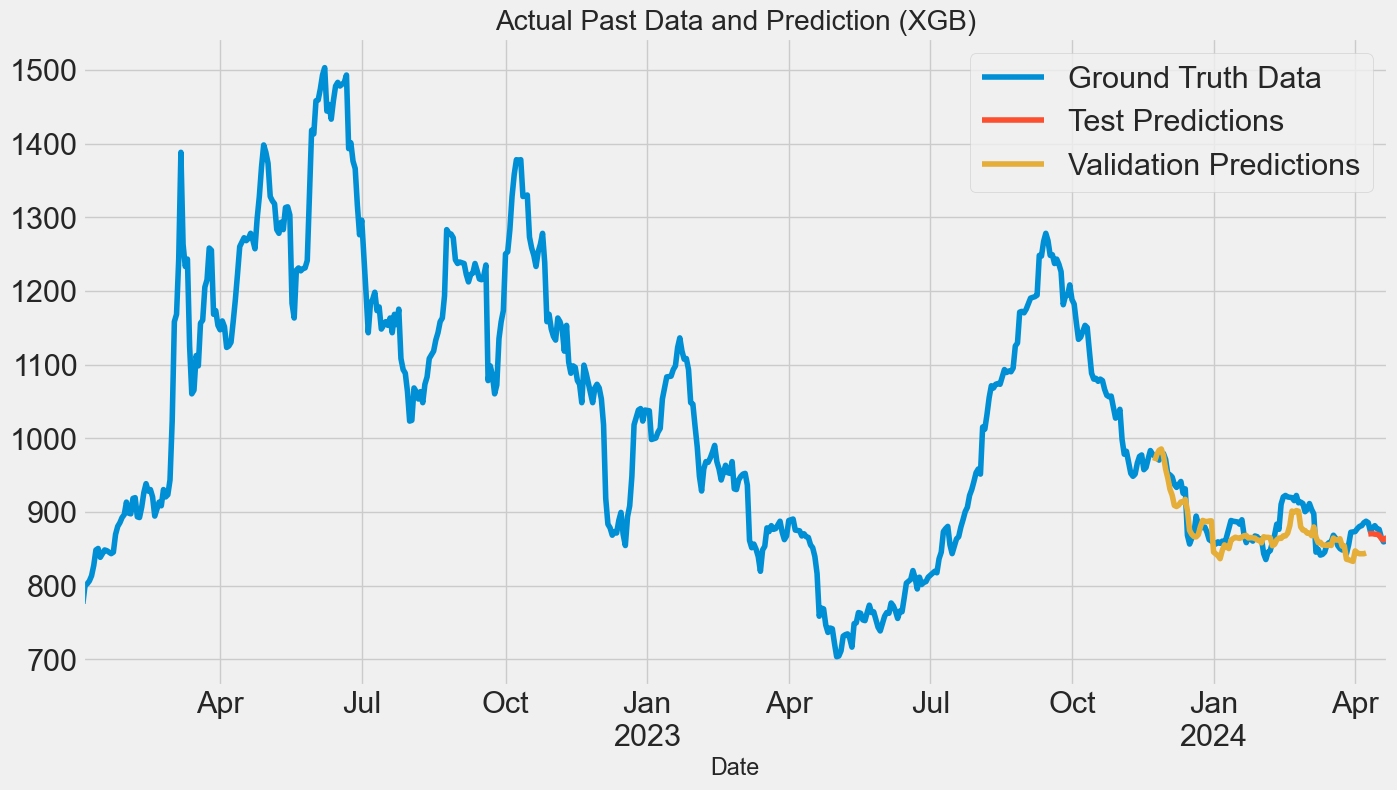

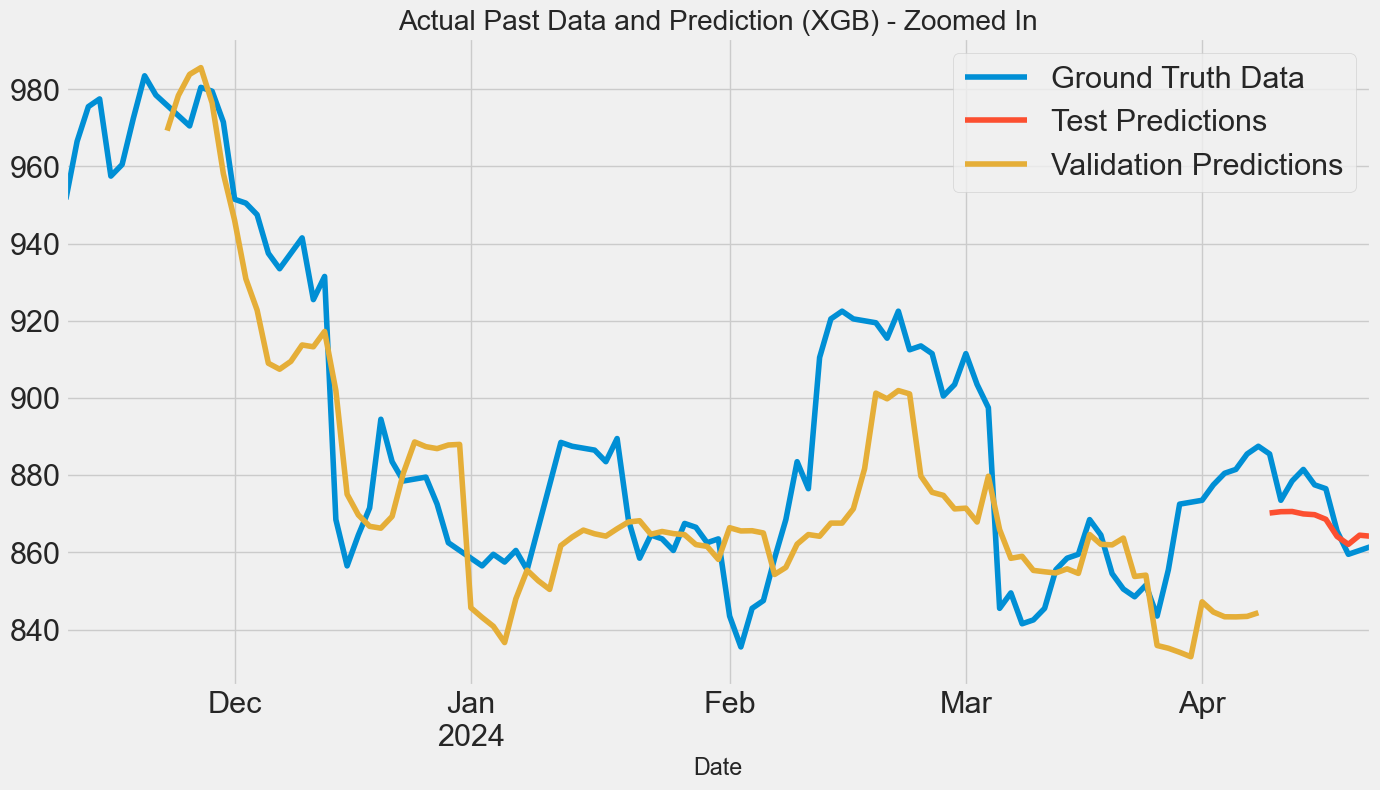

MAE Score on Validation set (XGB): 18.55
RMSE Score on Validation set (XGB): 22.82
MAPE Score on Validation set (XGB): 2.08%
MAE Score on Test set (XGB): 6.39
RMSE Score on Test set (XGB): 7.70
MAPE Score on Test set (XGB): 0.73%


In [48]:
validation_start_date = test_start_date - pd.Timedelta(days=validation_days)

train = train_val.loc[train_val.index<=validation_start_date]
validation = train_val.loc[(train_val.index > validation_start_date) & (train_val.index <= test_start_date)]

print(f"\nTraining set shape: {train.shape}")
print(f"Validation set shape: {validation.shape}")
print(f"Test set shape: {test.shape}\n")

train['Weekofyear'] = train['Weekofyear'].astype('int32')
validation['Weekofyear'] = validation['Weekofyear'].astype('int32')
test['Weekofyear'] = test['Weekofyear'].astype('int32')

# 모델 정의
xgb_model = XGBRegressor(
    base_score=0.5, booster='gbtree',
    n_estimators=10000, early_stopping_rounds=50,
    objective='reg:squarederror', max_depth=6,
    learning_rate=0.01, min_child_weight=1,
    subsample=0.8, colsample_bytree=0.8,
    gamma=0, reg_alpha=0, reg_lambda=1,
    random_state=42
)

X_train_val = train_val.drop(columns=[target_column + '_Price', 'Dubai', 'Brent', 'WTI'])
y_train_val = train_val[target_column + '_Price']
X_test = test.drop(columns=[target_column + '_Price', 'Dubai', 'Brent', 'WTI'])
y_test = test[target_column + '_Price']

tss = TimeSeriesSplit(n_splits=timeseriessplit)

mae_scores = []
rmse_scores = []
mape_scores = []

fold = 0
for train_idx, val_idx in tss.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=100)
    
    y_train_pred = xgb_model.predict(X_train)
    y_val_pred = xgb_model.predict(X_val)
    
    mae_scores.append(mean_absolute_error(y_val, y_val_pred))
    rmse_scores.append(mean_squared_error(y_val, y_val_pred, squared=False))
    mape_scores.append(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100)
    
    fold += 1

print(f'MAE for each fold: {mae_scores}')
print(f'Average MAE across folds: {np.mean(mae_scores):0.2f}')

print(f'RMSE for each fold: {rmse_scores}')
print(f'Average RMSE across folds: {np.mean(rmse_scores):0.2f}')

print(f'MAPE for each fold: {mape_scores}')
print(f'Average MAPE across folds: {np.mean(mape_scores):0.2f}')

# 최종 모델 학습
xgb_model.fit(X_train, y_train,
                  eval_set = [(X_val, y_val)],
                  verbose=100)

pred_val = xgb_model.predict(X_val)
pred_test = xgb_model.predict(X_test)

pred_val_df = pd.DataFrame(pred_val, index=X_val.index, columns=['pred_val'])
pred_test_df = pd.DataFrame(pred_test, index=X_test.index, columns=['pred_test'])

ts = ts_merge.merge(pred_val_df, how='left', left_index=True, right_index=True)
ts = ts.merge(pred_test_df, how='left', left_index=True, right_index=True)
ts

ax = ts[target_column + '_Price'].plot(figsize=(15,8))
ts['pred_test'].plot(ax=ax, style='-')
ts['pred_val'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB)')
plt.show();

# 특정 날짜 범위를 지정하여 확대
start_date = test_start_date - pd.Timedelta(days=validation_days * timeseriessplit)
end_date = last_date

# 데이터 필터링
ts_zoomed = ts.loc[start_date:end_date]

# 확대된 범위의 그래프 그리기
ax = ts_zoomed[target_column + '_Price'].plot(figsize=(15, 8))
ts_zoomed['pred_test'].plot(ax=ax, style='-')
ts_zoomed['pred_val'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB) - Zoomed In')
plt.show()

ts_clean = ts.dropna(subset=['pred_val', target_column + '_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb_val = mean_absolute_error(ts_clean[target_column + '_Price'], ts_clean['pred_val'])
score_rmse_xgb_val = np.sqrt(mean_squared_error(ts_clean[target_column + '_Price'], ts_clean['pred_val']))
score_mape_xgb_val = mean_absolute_percentage_error(ts_clean[target_column + '_Price'], ts_clean['pred_val'])

# 결과 출력
print(f'MAE Score on Validation set (XGB): {score_mae_xgb_val:0.2f}')
print(f'RMSE Score on Validation set (XGB): {score_rmse_xgb_val:0.2f}')
print(f'MAPE Score on Validation set (XGB): {score_mape_xgb_val:.2%}')  # 백분율 형식으로 출력

ts_clean = ts.dropna(subset=['pred_test', target_column + '_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb = mean_absolute_error(ts_clean[target_column + '_Price'], ts_clean['pred_test'])
score_rmse_xgb = np.sqrt(mean_squared_error(ts_clean[target_column + '_Price'], ts_clean['pred_test']))
score_mape_xgb = mean_absolute_percentage_error(ts_clean[target_column + '_Price'], ts_clean['pred_test'])

# 결과 출력
print(f'MAE Score on Test set (XGB): {score_mae_xgb:0.2f}')
print(f'RMSE Score on Test set (XGB): {score_rmse_xgb:0.2f}')
print(f'MAPE Score on Test set (XGB): {score_mape_xgb:.2%}')  # 백분율 형식으로 출력

In [26]:
y_test

Date
2024-04-09    885.5
2024-04-10    873.5
2024-04-11    878.5
2024-04-12    881.5
2024-04-15    877.5
2024-04-16    876.5
2024-04-17    865.5
2024-04-18    859.5
2024-04-19    860.5
2024-04-22    861.5
Freq: B, Name: Marine Gasoil 9_Price, dtype: float64

In [27]:
X_test

,Year,Quarter,Month,Dayofweek,Dayofmonth,Weekofyear,Dayofyear,Marine Gasoil 9_Price_lag14,Marine Gasoil 9_Price_lag30,Marine Gasoil 9_Price_lag91,Marine Gasoil 9_Price_lag182,Marine Gasoil 9_Price_rolling14,Marine Gasoil 9_Price_rolling30,Marine Gasoil 9_Price_rolling91,Marine Gasoil 9_Price_rolling182,trend,seasonal
Date,,,,,,,,,,,,,,,,,
2024-04-09,2024,2,4,1,9,15,100,854.5,911.5,950.5,930.5,859.603571,875.318333,884.656227,983.125549,872.400000,0.657251
2024-04-10,2024,2,4,2,10,15,101,850.5,900.5,947.5,941.5,860.400794,874.522222,884.080790,983.137057,871.795833,4.617918
2024-04-11,2024,2,4,3,11,15,102,848.5,903.5,937.5,953.5,861.343750,873.797917,883.537317,983.143201,871.216667,9.035997
2024-04-12,2024,2,4,4,12,15,103,851.5,911.5,933.5,958.5,862.239796,873.104762,883.004971,983.136185,870.691667,12.485695
2024-04-15,2024,2,4,0,15,16,106,843.5,903.5,937.5,951.5,863.071429,872.444444,882.483516,983.118132,870.250000,16.819553
2024-04-16,2024,2,4,1,16,16,107,855.5,897.5,941.5,1015.5,863.835714,871.830000,881.972527,983.085165,NaN,19.944176
2024-04-17,2024,2,4,2,17,16,108,872.5,845.5,925.5,1012.5,864.589286,871.258333,881.461538,983.038462,NaN,20.805185
2024-04-18,2024,2,4,3,18,16,109,873.0,849.5,931.5,1032.5,865.321429,870.694444,880.976190,982.977106,NaN,23.031135
2024-04-19,2024,2,4,4,19,16,110,873.5,841.5,868.5,1055.5,866.000000,870.250000,880.543956,982.906593,NaN,23.821194
